# Doobydobap Channel Analysis

In [75]:
# Import libraries

import googleapiclient.discovery
import json
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# to hide developer key

import DoobydobapConfig.config as config

In [76]:
# Create youtube object

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = config.DEVELOPER_KEY

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY)

doobydobap = 'UCh8gHdtzO2tXd593_bjErWg'

In [77]:
# function uses youtube API to get specified channel data

def get_channel_data(youtube, channel):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel
    )
    response = request.execute()
    return response

In [78]:
# get dooby channel stats and pretty print json output

dooby_stats = get_channel_data(youtube, doobydobap)

print(json.dumps(dooby_stats, indent=4, sort_keys=True))

{
    "etag": "VJal4fKSfeo79Shhxe-P6Dc8J1Q",
    "items": [
        {
            "contentDetails": {
                "relatedPlaylists": {
                    "likes": "",
                    "uploads": "UUh8gHdtzO2tXd593_bjErWg"
                }
            },
            "etag": "jCdXUB3Zgnjr0smtO8yGcx1Omi4",
            "id": "UCh8gHdtzO2tXd593_bjErWg",
            "kind": "youtube#channel",
            "snippet": {
                "country": "US",
                "customUrl": "doobydobap",
                "description": "Hi, I\u2019m Tina, aka Doobydobap!\n\nFood is the medium I use to tell stories and connect with people who share the same passion as I do. Whether it\u2019s because you\u2019re hungry at midnight or trying to learn how to cook, I hope you enjoy watching my content and recipes. Don't yuck my yum!\n\nwww.doobydobap.com\n",
                "localized": {
                    "description": "Hi, I\u2019m Tina, aka Doobydobap!\n\nFood is the medium I use to tell storie

In [79]:
# retrieve key for all of dooby's uploads

dooby_uploads_key = dooby_stats['items'][0]['contentDetails']['relatedPlaylists']['uploads']

In [80]:
# function gets all video keys from uploads playlist

def get_dooby_videos(youtube, playlistId):
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=playlistId,
        maxResults = 50
    )
    response = request.execute()
    video_ids = []
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part="contentDetails",
                playlistId=playlistId,
                maxResults = 50,
                pageToken = next_page_token
            )
            
            response = request.execute()
            
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
                
            next_page_token = response.get('nextPageToken')

    return video_ids

In [ ]:
# create array with all video ids

dooby_video_ids = get_dooby_videos(youtube, dooby_uploads_key)

print(json.dumps(dooby_video_ids, indent=1))

In [82]:
# gets specified data about all videos passed

def get_dooby_video_stats(youtube, video_ids):
    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet,statistics,contentDetails',
            id=",".join(video_ids[i:i+50])
        )
        
        response = request.execute()
        
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Date_published = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount'],
                               Duration = video['contentDetails']['duration'])
            all_video_stats.append(video_stats)
    
    return all_video_stats

In [ ]:
# create dictionary with all video data

dooby_video_stats = get_dooby_video_stats(youtube, dooby_video_ids)

print(json.dumps(dooby_video_stats, indent=4, sort_keys=True))

In [84]:
# create dataframe

dooby_df = pd.DataFrame(dooby_video_stats)

dooby_df

,Title,Date_published,Views,Likes,Comments,Duration
0,The Muffin Man,2022-03-12T00:28:40Z,291422,12755,862,PT17M32S
1,Flying to London,2022-03-09T22:27:43Z,454250,19447,1308,PT17M58S
2,What I ate Flying Business Class Korean Air 🇰🇷...,2022-03-08T07:38:14Z,2815621,282480,1453,PT58S
3,(not so) Teenage Angst,2022-03-02T16:26:23Z,418146,18442,1401,PT22M56S
4,can't smell :s,2022-02-26T15:12:43Z,319937,14808,1241,PT14M35S
...,...,...,...,...,...,...
138,"KOREAN STREET FOOD VLOG #1// Gwangjang Market,...",2021-04-18T18:30:09Z,319536,11904,433,PT10M38S
139,CHILI OIL BIANG BIANG NOODLES,2021-04-03T22:11:29Z,1396519,84543,571,PT50S
140,Chorizo Kimchi Fried Rice,2021-03-27T00:10:14Z,130651,5636,161,PT6M59S
141,Tonkotsu Ramen - Behind the Scenes,2021-02-27T01:21:44Z,223590,8807,345,PT8M40S


In [85]:
# check data types

dooby_df.dtypes

Title             object
Date_published    object
Views             object
Likes             object
Comments          object
Duration          object
dtype: object

In [86]:
# convert all data types to data types that accurately reflect data and add year and month column

dooby_df['Title'] = dooby_df['Title'].astype("string")

dooby_df['Date_published'] = pd.to_datetime(dooby_df['Date_published']).dt.date

dooby_df['Views'] = pd.to_numeric(dooby_df['Views'])

dooby_df['Likes'] = pd.to_numeric(dooby_df['Likes'])

dooby_df['Comments'] = pd.to_numeric(dooby_df['Comments'])

dooby_df['Duration'] = dooby_df['Duration'].astype("string")

dooby_df['year'] = pd.DatetimeIndex(dooby_df['Date_published']).year

dooby_df['month'] = pd.DatetimeIndex(dooby_df['Date_published']).month

In [87]:
# check to make sure it worked

dooby_df.dtypes

Title             string
Date_published    object
Views              int64
Likes              int64
Comments           int64
Duration          string
year               int64
month              int64
dtype: object

In [88]:
# make a copy so any original dataframe is preserved

normalized_dooby_df = dooby_df.copy()

In [89]:
# function to normalize data with min max scaling

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

In [90]:
# normalize numerical data columns

normalized_dooby_df['Views'] = min_max_scaling(normalized_dooby_df['Views'])

normalized_dooby_df['Likes'] = min_max_scaling(normalized_dooby_df['Likes'])

normalized_dooby_df['Comments'] = min_max_scaling(normalized_dooby_df['Comments'])

In [91]:
# also going to convert duration column to just numbers so can do something with it

def convert_to_digits(series):
    new_string = ""
    for c in series:
        if c.isdigit():
            new_string += c
    return new_string

In [92]:
normalized_dooby_df["Duration"] = normalized_dooby_df["Duration"].apply(convert_to_digits)

normalized_dooby_df["Duration"] = pd.to_numeric(normalized_dooby_df["Duration"])

normalized_dooby_df['Duration'] = min_max_scaling(normalized_dooby_df['Duration'])

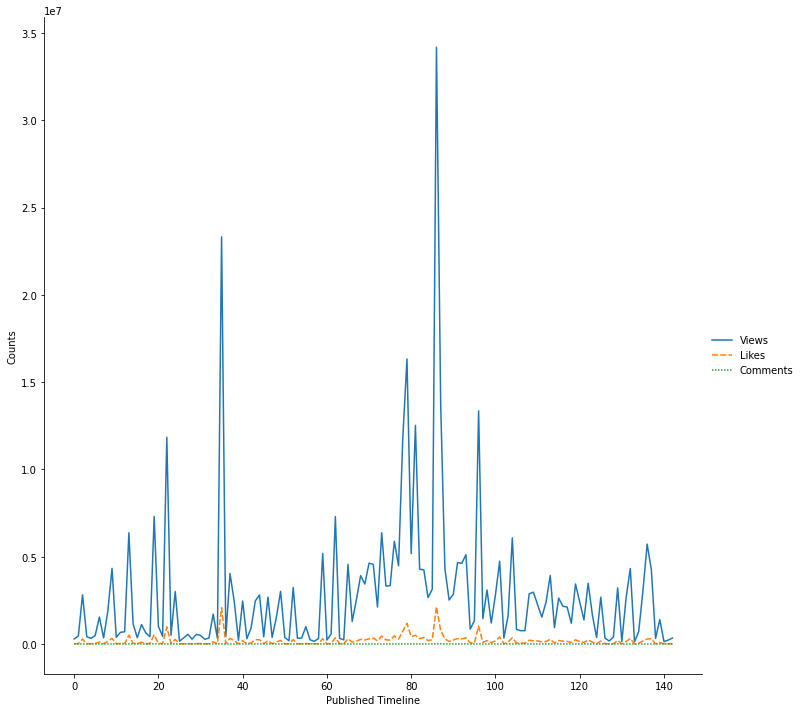

In [137]:
# graph of unmodified data, as you can see views dwarfs other data

regular_graph = sns.relplot(data=dooby_df[['Views', 'Likes', 'Comments']], kind="line", height=10);

regular_graph.set(xlabel="Published Timeline", ylabel="Counts");

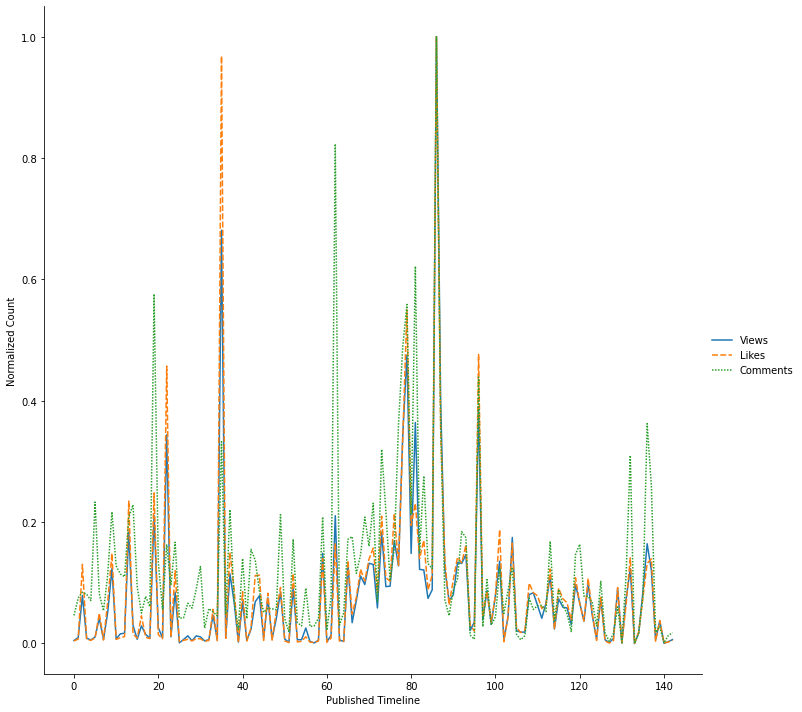

In [136]:
# graph of normalized data to get a better idea of how stuff is performing with each other

normalized_graph = sns.relplot(data=normalized_dooby_df[['Views', 'Likes', 'Comments']], kind="line", height=10);

normalized_graph.set(xlabel="Published Timeline", ylabel="Normalized Count");

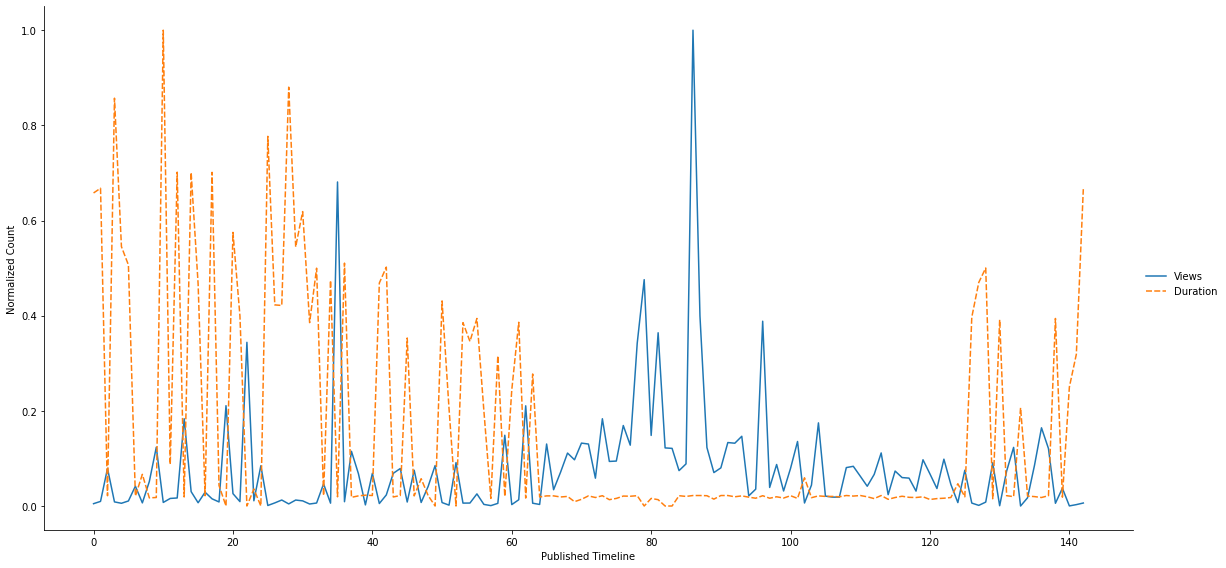

In [135]:
# graph to show relationship between views and duration

normalized_graph = sns.relplot(data=normalized_dooby_df[['Views', 'Duration']], kind="line", height=8, aspect=2);

normalized_graph.set(xlabel="Published Timeline", ylabel="Normalized Count");

In [96]:
dooby_df.sort_values('Views', ascending=False).head(20)

,Title,Date_published,Views,Likes,Comments,Duration,year,month
86,Do You Ever Dream About.. Chili Oil Ramen?,2021-09-27,34192685,2139826,15619,PT59S,2021,9
35,Nostalgia is a powerful ingredient,2021-11-30,23326004,2072060,5292,PT52S,2021,11
79,What I Ate for Lunch in 7/11 Korea,2021-10-06,16331000,1177998,8792,PT1M,2021,10
87,GARLIC WHOLE FRIED CHICKEN,2021-09-24,13736600,758977,5714,PT59S,2021,9
96,This is what I ate in a gas stop in Korea,2021-09-06,13355715,1021812,6939,PT58S,2021,9
81,My biggest fear when posting content,2021-10-05,12528770,496906,9766,PT36S,2021,10
22,Cadaver Dissection,2022-01-05,11843270,980464,2659,PT1M,2022,1
78,I can't believe that I didn't want this before,2021-10-07,11787245,721986,7703,PT58S,2021,10
19,Deal Breakers,2022-01-12,7307864,533798,9060,PT1M,2022,1
62,"How I stay ""skinny""",2021-10-22,7298385,356415,12886,PT45S,2021,10


In [97]:
dooby_df.sort_values('Views').head(20)

,Title,Date_published,Views,Likes,Comments,Duration,year,month
133,KOREAN STREET FOOD VLOG #2 l Noryangjin Fish M...,2021-05-29,124029,3874,146,PT5M44S,2021,5
140,Chorizo Kimchi Fried Rice,2021-03-27,130651,5636,161,PT6M59S,2021,3
130,KOREAN STREET FOOD VLOG #3 | Jeju 5 Day Market,2021-06-05,143383,5239,172,PT10M31S,2021,6
57,Moody & Tacos l NYC Vlog,2021-10-28,152364,7489,596,PT4M3S,2021,10
25,21 lessons from 2021 l Craziest year so far,2021-12-31,161140,10876,793,PT20M45S,2021,12
127,Corn Rice and Miso Soup,2021-06-18,170100,5374,200,PT12M37S,2021,6
51,"Second to Last Day-- empanadas, estella, and a...",2021-11-07,185502,7109,437,PT5M39S,2021,11
39,"Seoul Vlog - brunch, my first interview, eatin...",2021-11-24,203513,7644,495,PT6M1S,2021,11
141,Tonkotsu Ramen - Behind the Scenes,2021-02-27,223590,8807,345,PT8M40S,2021,2
60,Eating at Hip n Cool Restos l NYC Vlog,2021-10-25,224946,8077,482,PT6M42S,2021,10


In [98]:
dooby_df_copy = dooby_df.copy()

In [99]:
dooby_df_copy["Duration"] = dooby_df_copy["Duration"].apply(convert_to_digits)

dooby_df_copy["Duration"] = pd.to_numeric(dooby_df_copy["Duration"])

In [100]:
avg_shorts_views = int(dooby_df_copy[dooby_df_copy['Duration'] <= 60]['Views'].mean())

avg_normal_views = int(dooby_df_copy[dooby_df_copy['Duration'] > 60]['Views'].mean())

num_of_videos = len(dooby_df_copy.index)

num_of_short_videos = len(dooby_df_copy[dooby_df_copy['Duration'] <= 60])

num_of_normal_videos = len(dooby_df_copy[dooby_df_copy['Duration'] > 60])

In [101]:
print(f"Shorts average viewers = {avg_shorts_views}")
print(f"Not shorts average viewers = {avg_normal_views}")
print(f"Num of videos = {num_of_videos}")
print(f"Num of short videos = {num_of_short_videos}")
print(f"Num of not short videos = {num_of_normal_videos}")

Shorts average viewers = 4281805
Not shorts average viewers = 409787
Num of videos = 143
Num of short videos = 91
Num of not short videos = 52


In [102]:
def get_percent_difference(a, b):
    difference = abs(a - b)
    added = a + b
    return (difference / (added / 2)) * 100

In [110]:
percent_difference_views = round(get_percent_difference(avg_shorts_views, avg_normal_views), 2)

percentage_shorts = round((91/143) * 100, 2)

percentage_normal = round((52/143) * 100, 2)

num_of_short_views = dooby_df_copy[dooby_df_copy['Duration'] <= 60]['Views'].sum()

num_of_normal_views = dooby_df_copy[dooby_df_copy['Duration'] > 60]['Views'].sum()

total_views = dooby_df_copy['Views'].sum()

percentage_shorts_views = round((num_of_short_views/total_views) * 100, 2)

percentage_normal_views = round((num_of_normal_views/total_views) * 100, 2)

In [111]:
print(f"Percent difference views = {percent_difference_views}")
print(f"Percentage of short videos = {percentage_shorts}")
print(f"Percentage of not short videos = {percentage_normal}")
print(f"Total short video views = {num_of_short_views}")
print(f"Total not short video views = {num_of_normal_views}")
print(f"Total views = {total_views}")
print(f"Percentage of short views = {percentage_shorts_views}")
print(f"Percentage of not short views = {percentage_normal_views}")

Percent difference views = 165.06
Percentage of short videos = 63.64
Percentage of not short videos = 36.36
Total short video views = 389644271
Total not short video views = 21308935
Total views = 410953206
Percentage of short views = 94.81
Percentage of not short views = 5.19


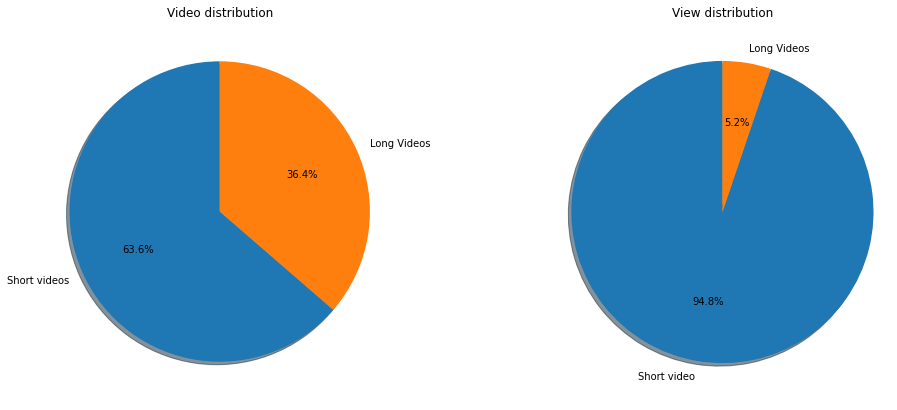

In [134]:
labels = 'Short videos', 'Long Videos'
sizes = [percentage_shorts, percentage_normal]
labels_2 = 'Short video', 'Long Videos'
sizes_2 = [percentage_shorts_views, percentage_normal_views]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7));
fig.subplots_adjust(wspace=.5)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
ax1.axis('equal');
ax1.set_title('Video distribution');
ax2.pie(sizes_2, labels=labels_2, autopct='%1.1f%%',
        shadow=True, startangle=90);
ax2.axis('equal');
ax2.set_title('View distribution');